<a href="https://colab.research.google.com/github/jessenl/pneumonia-diagnosis/blob/main/pneumonia_diagnosys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import files
import stat
import shutil
import zipfile
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from google.colab import files
from google.colab.patches import cv2_imshow
import random
%matplotlib inline

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia 

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
OLD_DATA_DIR = '/content/chest_xray/'
NEW_DATA_DIR = '/content/x-ray/'
PASTAS = ['train', 'test', 'val']
CATEGORIAS = ['NORMAL', 'PNEUMONIA']

def baixa_dataset():
  files.upload() #upload kaggle.json
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
  !unzip -q chest-xray-pneumonia.zip -d .
  !rm -rf chest-xray-pneumonia.zip

def cria_dataframe(origem):
  dataframe = []
  for pasta in PASTAS:
    for categoria in CATEGORIAS:
      caminho = origem + pasta + '/' + categoria + '/'
      for nome_arq in os.listdir(caminho):
        dataframe.append([caminho + nome_arq, categoria])
  dataframe = pd.DataFrame(data=dataframe, columns= ['Caminho', 'Categoria'])
  return dataframe

def aplica_filtros(caminho_img):
  img = cv2.imread(caminho_img, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (300, 300))
  clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
  img = clahe.apply(img)
  return img

def cria_dir():
  pastas = ['train', 'val', 'test']
  categorias   = ['NORMAL', 'PNEUMONIA']
  os.mkdir(NEW_DATA_DIR)
  for pasta in PASTAS:
    os.mkdir(NEW_DATA_DIR + '/' + pasta)
    for categoria in CATEGORIAS:
      os.mkdir(NEW_DATA_DIR +  '/' + pasta + '/' + categoria + '/')  

def preenche_dir(data):
  for etapa in data.keys(): # etapa pode ser validacao, teste, treino
    for a in data[etapa]:
      cl1 = aplica_filtros(a)
      if a.split('/')[-2] == 'NORMAL':
        os.chdir(NEW_DATA_DIR + '/' + etapa + '/' + 'NORMAL/')
      elif a.split('/')[-2] == 'PNEUMONIA':
        os.chdir(NEW_DATA_DIR + '/' + etapa + '/' + 'PNEUMONIA/')
      cv2.imwrite(a.split('/')[-1], cl1)
      os.chdir('/content/')

def compara_aleatorio():
  antes = cria_dataframe(OLD_DATA_DIR)
  depois = cria_dataframe(NEW_DATA_DIR)
  
  n = random.randint(0,len(antes)-1)
  
  caminho_imagem_aleatoria = antes['Caminho'][n]
  so_o_nome = caminho_imagem_aleatoria.split('/')[-1]
  
  imagem_antes = cv2.imread(caminho_imagem_aleatoria)
  imagem_antes = cv2.resize(imagem_antes, (300, 300)) 
  
  correspondente = depois[ depois['Caminho'].apply(lambda x: x.split('/')[-1]) == so_o_nome]
  correspondente = np.asarray(correspondente)
  
  caminho_depois = correspondente[0][0]
  categoria = correspondente[0][1]
  
  imagem_depois = cv2.imread(caminho_depois)
  imagem_depois = cv2.resize(imagem_depois, (300, 300)) 
  
  imagens_combinadas = cv2.hconcat([imagem_antes, imagem_depois])
  
  print(categoria)
  
  cv2.imwrite('exemplo.jpeg', imagens_combinadas)
  nova_imagem = cv2.imread('/content/exemplo.jpeg')
  cv2_imshow(nova_imagem)

def matriz_confusao(model):
  mat_confu = [[0, 0], [0, 0]]
  for nome_pasta in os.listdir(NEW_DATA_DIR + '/test/'):
    # predict images
    for fn in os.listdir(NEW_DATA_DIR + '/test/' + nome_pasta):
      path = NEW_DATA_DIR + '/test/' + nome_pasta + '/' + fn
      img = image.load_img(path, target_size=(300,300))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis =0)

      images = np.vstack([x])
      classes = model.predict(images, batch_size = 10)
      if classes[0]> 0.5: # modelo disse que é pneumonia
        if nome_pasta == 'PNEUMONIA':
          mat_confu[0][0] += 1
        elif nome_pasta == 'NORMAL':
          mat_confu[0][1] += 1 # falso +
      else: # modelo disse que não é pneumonia
        if nome_pasta == 'PNEUMONIA':
          mat_confu[1][0] += 1  # falso -
        elif nome_pasta == 'NORMAL':
          mat_confu[1][1] += 1 
  print(mat_confu)

In [ ]:
baixa_dataset()

Saving kaggle.json to kaggle (1).json
kaggle.json
100% 2.29G/2.29G [00:20<00:00, 55.6MB/s]
100% 2.29G/2.29G [00:20<00:00, 119MB/s] 


In [ ]:
df = cria_dataframe(OLD_DATA_DIR)
X = df['Caminho']
y = df['Categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
cria_dir()
preenche_dir({'train': X_train, 'val': X_val, 'test': X_test})

PNEUMONIA


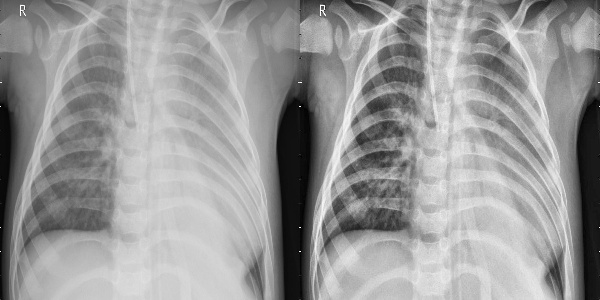

In [ ]:
compara_aleatorio()

In [ ]:
model = tf.keras.models.Sequential([
  
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
  
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), # 512 neuron hidden layer
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for ('normal') clas and 1 for ('pneumonia') class
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# to get the summary of the model
model.summary()

# configure the model for traning by adding metrics
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [ ]:
dados_ger_treino = ImageDataGenerator(rescale = 1/255)
dados_ger_val = ImageDataGenerator(rescale = 1/255)

gerador_treino = dados_ger_treino.flow_from_directory(
    NEW_DATA_DIR + 'train/',
    target_size = (300,300),
    batch_size = 128,
    class_mode = 'binary'
)

gerador_validacao = dados_ger_val.flow_from_directory(
    NEW_DATA_DIR + 'val/',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary'
)

# training the model
historico = model.fit(
    gerador_treino,
    steps_per_epoch = 10,
    epochs = 10,
    #class_weight=dict(enumerate(class_weights)),
    validation_data = gerador_validacao
)

Found 3513 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.
Epoch 1/10
10/10 [==============================] - 108s 11s/step - loss: 0.6878 - accuracy: 0.5434 - val_loss: 0.6097 - val_accuracy: 0.7131
Epoch 2/10
10/10 [==============================] - 109s 11s/step - loss: 0.6151 - accuracy: 0.7103 - val_loss: 0.5837 - val_accuracy: 0.7131
Epoch 3/10
10/10 [==============================] - 108s 11s/step - loss: 0.5886 - accuracy: 0.7565 - val_loss: 3.0652 - val_accuracy: 0.2980
Epoch 4/10
10/10 [==============================] - 108s 11s/step - loss: 1.2768 - accuracy: 0.6340 - val_loss: 0.6119 - val_accuracy: 0.7336
Epoch 5/10
10/10 [==============================] - 108s 11s/step - loss: 0.3406 - accuracy: 0.8540 - val_loss: 0.3350 - val_accuracy: 0.8830
Epoch 6/10
10/10 [==============================] - 109s 11s/step - loss: 0.3070 - accuracy: 0.8711 - val_loss: 0.2922 - val_accuracy: 0.8685
Epoch 7/10
10/10 [==============================] - 109s 11s/ste

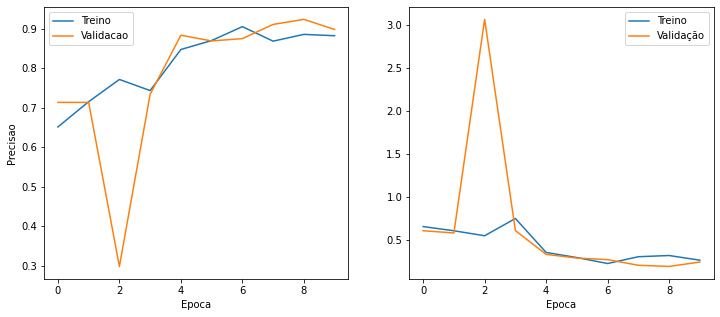

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(historico.history['accuracy'], label='Treino')
ax1.plot(historico.history['val_accuracy'], label="Validacao")
ax1.set_ylabel('Precisao')
ax1.set_xlabel('Epoca')

ax2.plot(historico.history['loss'], label='Treino')
ax2.plot(historico.history['val_loss'], label='Validação')
ax2.set_xlabel('Epoca')


handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)


In [ ]:
# load new unseen dataset
test_datagen = ImageDataGenerator(rescale = 1/255)
eval_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = eval_datagen.flow_from_directory(
    NEW_DATA_DIR + 'test/',
    target_size = (300, 300),
    batch_size = 128, 
    class_mode = 'binary'
)

eval_result = model.evaluate_generator(test_generator, 624)
print('loss rate at evaluation data :', eval_result[0])
print('accuracy rate at evaluation data :', eval_result[1])


Found 1172 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss rate at evaluation data : 0.2293359488248825
accuracy rate at evaluation data : 0.9027303457260132


In [ ]:
print(len(os.listdir(NEW_DATA_DIR + '/test/NORMAL/')), ', ', len(os.listdir(NEW_DATA_DIR + '/test/PNEUMONIA/')))
print(len(os.listdir(NEW_DATA_DIR + '/train/NORMAL/')), ', ', len(os.listdir(NEW_DATA_DIR + '/train/PNEUMONIA/')))
print(len(os.listdir(NEW_DATA_DIR + '/val/NORMAL/')), ', ', len(os.listdir(NEW_DATA_DIR + '/val/PNEUMONIA/')))


300 ,  872
947 ,  2566
336 ,  835


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights